## Environment Setup

In [1]:
import uproot
import awkward
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from tqdm import tqdm_notebook as tqdm

from preprocessing import make_graph_xy, make_graph_etaphi, make_graph_knn, make_graph_kdtree
from graph import draw_sample_validation, make_sparse_graph, graph_from_sparse

from scipy.sparse import find

%load_ext autoreload
%autoreload 2

In [2]:
fname = '../data/D41/double_photon_flatE/test.root'

#preprocessing_algo = make_graph_xy
#preprocessing_r = 3.0

preprocessing_algo = make_graph_etaphi
grouping_algo = make_graph_knn
preprocessing_r = 0.07
layer_norm = 100

preprocessing_string = "test_double_photon"
#preprocessing_string = 'D41_muon_xy_r' + str(preprocessing_r) + "_AdjacentLayerOrOnlyConnection"
#preprocessing_string = 'D41_muon_phieta_r' + str(preprocessing_r) + "_layernorm" + str(layer_norm) + "_AdjacentLayerOrOnlyConnection"

In [3]:
def plotHist(axes, data, xlabel, ylabel, title, Nbins = 100, range=None, xlog=False, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if xlog:
        axes.set_xscale('log')
        Nbins = np.logspace(np.log10(data.min()),np.log10(data.max()),Nbins)
    return axes.hist(data, bins=Nbins, range=range, histtype='step', log=ylog); 
    
def plotHist_absxlog(axes, data, xlabel, ylabel, title, Nbins = 100, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.set_xscale('log')
    Nbins = np.logspace(np.log10(np.abs(data).min()),np.log10(np.abs(data).max()),Nbins)
    axes.hist(data, bins=Nbins, histtype='step', log=ylog); 
    
def plotHist_layers(data, ylabel, title, xlabel="Layer", log=True):
    fig,axes = plt.subplots(figsize=(10, 7));
    axes.set_xlabel(xlabel)
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.hist(data, range=(0,60), bins=np.arange(62)-0.5, log=log, histtype='step', linewidth = '1.5');
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    return fig

In [4]:
rootfile = uproot.open(fname)['ana']['hgc']
figs = []
#absorber_weights from https://github.com/cms-sw/cmssw/blob/master/RecoLocalCalo/HGCalRecProducers/python/HGCalRecHit_cfi.py#L61
absorber_weights_V9 = (0.0,      # there is no layer zero
                              8.366557, # Gev
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              10.425456,  
                              31.497849,  
                              51.205434,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              52.030486,  
                              71.265149,  
                              90.499812,  
                              90.894274,  
                              90.537470,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205,  
                              89.786205)

absorber_weights_V10 = (0.0,      # there is no layer zero
                               8.894541,  # Gev
                               10.937907,
                               10.937907,
                               10.937907,
                               10.937907,
                               10.937907,
                               10.937907,
                               10.937907,
                               10.937907,
                               10.932882,
                               10.932882,
                               10.937907,
                               10.937907,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               10.938169,
                               32.332097,
                               51.574301,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               51.444192,
                               69.513118,
                               87.582044,
                               87.582044,
                               87.582044,
                               87.582044,
                               87.582044,
                               87.214571,
                               86.888309,
                               86.929520,
                               86.929520,
                               86.929520)

#absorber_weights = absorber_weights_V9
#V9 for data produced with geometry D30
#absorber_weights = absorber_weights_V10
#V10 for data produced with geometry D41

In [5]:
rootfile.keys()


[b'event',
 b'lumi',
 b'run',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'genpart_eta',
 b'genpart_phi',
 b'genpart_pt',
 b'genpart_energy',
 b'genpart_dvx',
 b'genpart_dvy',
 b'genpart_dvz',
 b'genpart_fbrem',
 b'genpart_pid',
 b'genpart_gen',
 b'genpart_reachedEE',
 b'genpart_fromBeamPipe',
 b'genpart_posx',
 b'genpart_posy',
 b'genpart_posz',
 b'rechit_eta',
 b'rechit_phi',
 b'rechit_pt',
 b'rechit_energy',
 b'rechit_x',
 b'rechit_y',
 b'rechit_z',
 b'rechit_time',
 b'rechit_thickness',
 b'rechit_layer',
 b'rechit_wafer_u',
 b'rechit_wafer_v',
 b'rechit_cell_u',
 b'rechit_cell_v',
 b'rechit_detid',
 b'rechit_isHalf',
 b'rechit_flags',
 b'rechit_cluster2d',
 b'cluster2d_eta',
 b'cluster2d_phi',
 b'cluster2d_pt',
 b'cluster2d_energy',
 b'cluster2d_x',
 b'cluster2d_y',
 b'cluster2d_z',
 b'cluster2d_layer',
 b'cluster2d_nhitCore',
 b'cluster2d_nhitAll',
 b'cluster2d_multicluster',
 b'cluster2d_rechits',
 b'cluster2d_rechitSeed',
 b'multiclus_eta',
 b'multiclus_phi',
 b'multiclus_pt',
 b'multicl

In [6]:
rechit = rootfile.arrays([b'rechit_thickness', b'rechit_energy',  b'rechit_layer',  b'rechit_time', \
                          b'rechit_x', b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi'])
rechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1
NEvents = rechit[b'rechit_z'].shape[0]
simcluster = rootfile.arrays([b'simcluster_hits_indices',  b'simcluster_energy', b'simcluster_eta', b'simcluster_phi', b'simcluster_layers', b'simcluster_pid'])
#simcluster = rootfile.arrays([b'simcluster_hits_indices',  b'simcluster_energy', b'simcluster_eta', b'simcluster_phi', b'simcluster_layers'])

In [7]:
sim_indices = awkward.fromiter(simcluster[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]

In [8]:
simcluster_rechit_cut = 3 #min no. of rechits in simcluster requirement (exclusive)
simcluster_mask = awkward.JaggedArray.fromcounts(valid_sim_indices.counts,valid_sim_indices.flatten().counts > simcluster_rechit_cut)
simcluster_mask = simcluster_mask & (simcluster[b'simcluster_energy'] > 1.0)
valid_sim_indices = valid_sim_indices[simcluster_mask]
for key, value in simcluster.items():
    if (key == b'simcluster_hits_indices'): continue
    simcluster[key] = awkward.fromiter(value)[simcluster_mask]

In [9]:
valid_sim_indices_eventlevel = valid_sim_indices.flatten(1)
valid_sim_indices_eventlevel = awkward.fromiter(map(np.unique, valid_sim_indices_eventlevel))

In [10]:
simmatched_rechit = {}
for key, value in rechit.items():
    simmatched_rechit[key] = value[valid_sim_indices_eventlevel]

In [11]:
def rewrap_into_simcluster_structure(filelevel_array):
    return awkward.JaggedArray.fromcounts(valid_sim_indices.counts,\
        (awkward.JaggedArray.fromcounts(valid_sim_indices.content.counts, filelevel_array)))

rechit_simcluster = {}
select_rechit_simcluster = [b'rechit_energy', b'rechit_layer', b'rechit_eta', b'rechit_phi']
for key, value in rechit.items():
    if key not in select_rechit_simcluster: continue
    rechit_simcluster[key] = value[valid_sim_indices.flatten(1)]
    rechit_simcluster[key] = rewrap_into_simcluster_structure(rechit_simcluster[key].content)
    
#corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy'] * rewrap_into_simcluster_structure(np.take(absorber_weights,rechit_simcluster[b'rechit_layer'].content.content))
corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy']

## Rechits Energy Distribution in different Cell Thickness Regions

In [12]:
def plotRechitEnergy_Thickness(thickness, rechit_energy, rechit_thickness, title_target):
    title = '%s Energy Distribution for %d um' % (title_target, thickness)
    if thickness == 100:
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 99.0) & (rechit_thickness.flatten() < 121.0)]
#       e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 99.0) & (rechit_pd[b'rechit_thickness'] < 121.0)][b'rechit_energy']
    if thickness == 200:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 199.0) & (rechit_pd[b'rechit_thickness'] < 201.0)][b'rechit_energy']
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 199.0) & (rechit_thickness.flatten() < 201.0)]
    if thickness == 300:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 299.0) & (rechit_pd[b'rechit_thickness'] < 301.0)][b'rechit_energy']
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 299.0) & (rechit_thickness.flatten() < 301.0)]
    if thickness == -1:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 301.0)][b'rechit_energy']
        e = rechit_energy.flatten()[rechit_thickness.flatten() > 301.0]
        title = "%s Energy Distribution for Scintillator Backing Calorimeter" % (title_target)
    
    fig = plt.figure(figsize=(17,5));
    ax1 = fig.add_subplot(121);
    plotHist(ax1, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, ylog=True)
    ax2 = fig.add_subplot(122);
    plotHist(ax2, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, xlog=True, ylog=True)
    return fig;


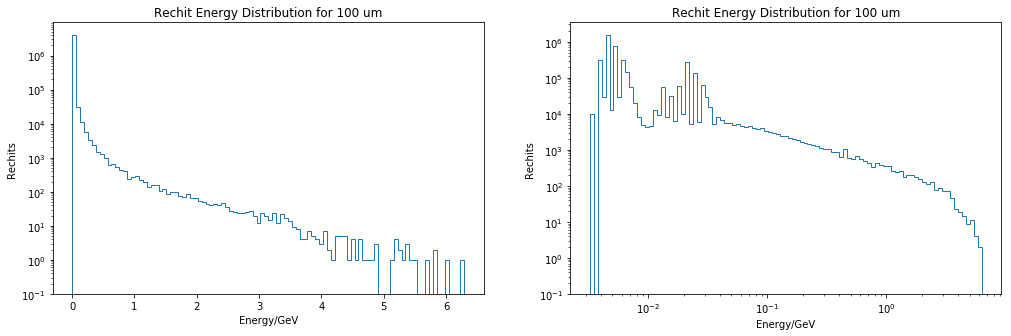

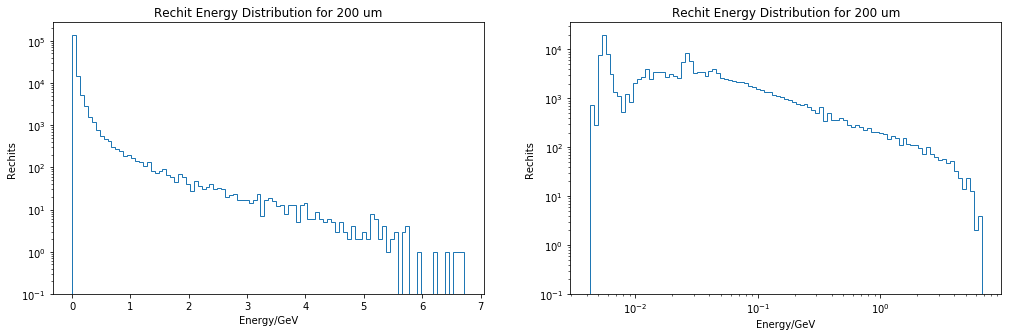

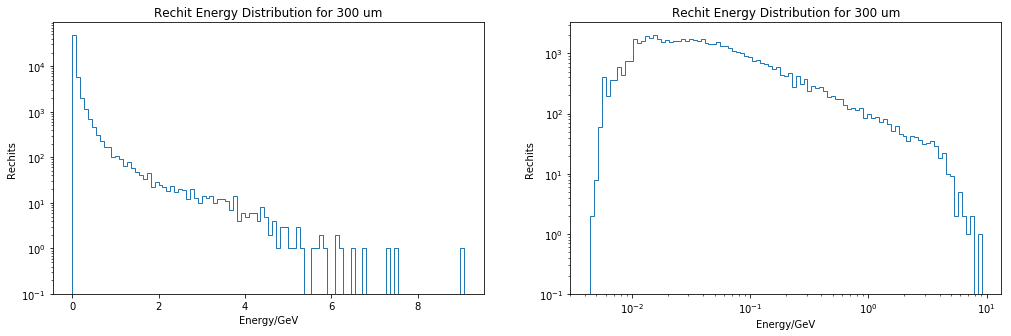

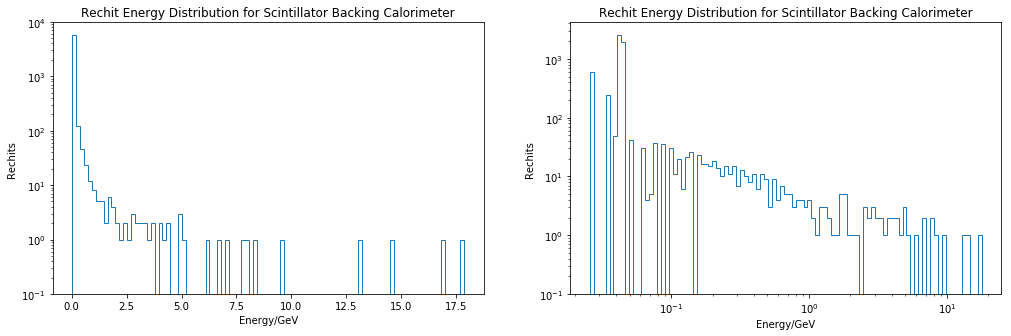

In [13]:
figs.append(plotRechitEnergy_Thickness(100, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(200, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(300, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));

## Rechit Multiplicity across layers

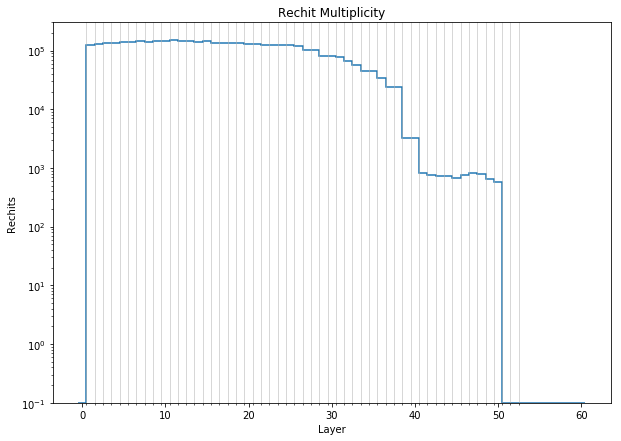

In [14]:
figs.append(plotHist_layers(rechit[b'rechit_layer'].content, "Rechits", "Rechit Multiplicity"))


## Rechit x/y distribution across layers

In [15]:
def plotRechitDistribution_Layers(rechit_layer, rechit_pos, title_target):
    fig,axes = plt.subplots(figsize=(12, 7));
    axes.set_xlabel("Layer")
    axes.set_ylabel("%s" % (title_target))
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_title("%s distribution in Layers" % (title_target))
    h = axes.hist2d(rechit_layer.content, rechit_pos.content, bins=(np.arange(62)-0.5, 500), range=((-0.5,60.5),(-250.0, 250.0)), norm=mpl.colors.LogNorm());
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    plt.colorbar(h[3], ax=axes);
    return fig

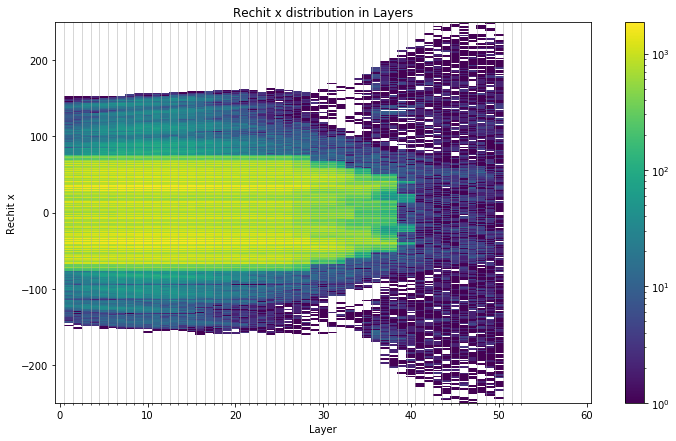

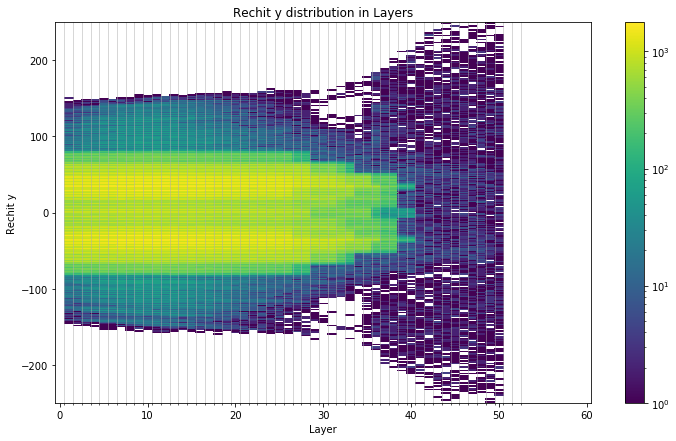

In [16]:
figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_x'], 'Rechit x'));
figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_y'], 'Rechit y'));

## Sim-matched Rechits Energy Distribution in different Cell Thickness Regions

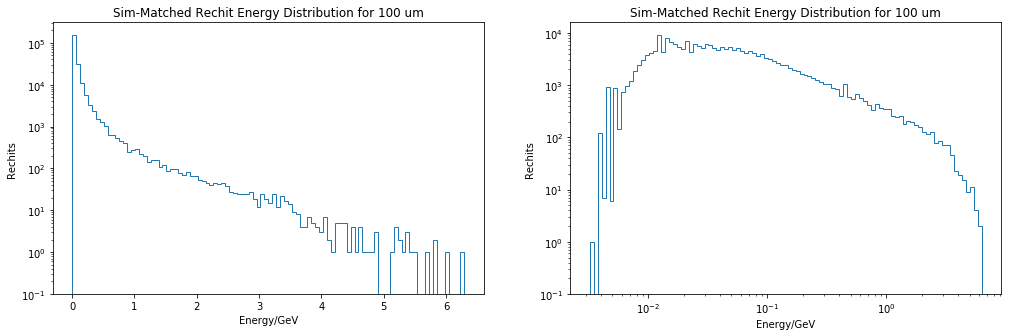

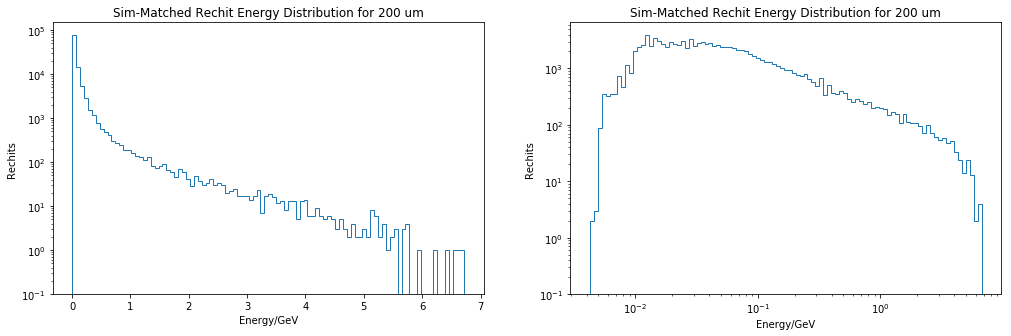

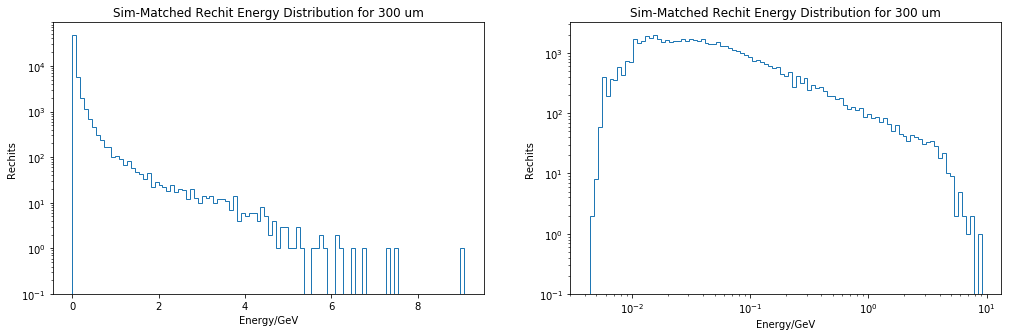

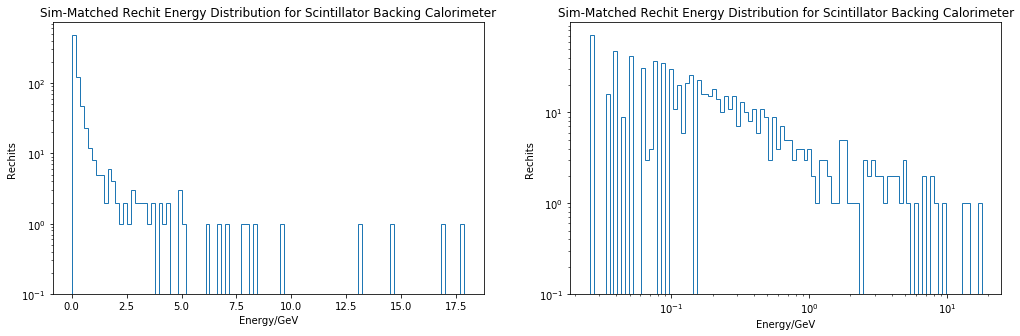

In [17]:
figs.append(plotRechitEnergy_Thickness(100, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(200, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(300, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));



## Sim-matched Rechit Multiplicity across layers

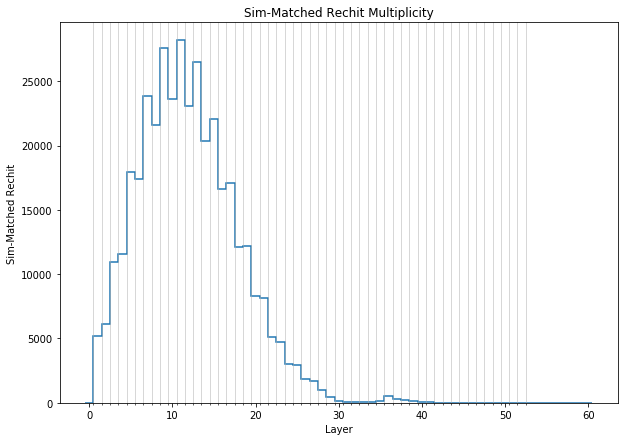

In [18]:
figs.append(plotHist_layers(simmatched_rechit[b'rechit_layer'].content, "Sim-Matched Rechit",\
                            "Sim-Matched Rechit Multiplicity", log=False))

## Sim-matched Rechit x/y distribution across layers

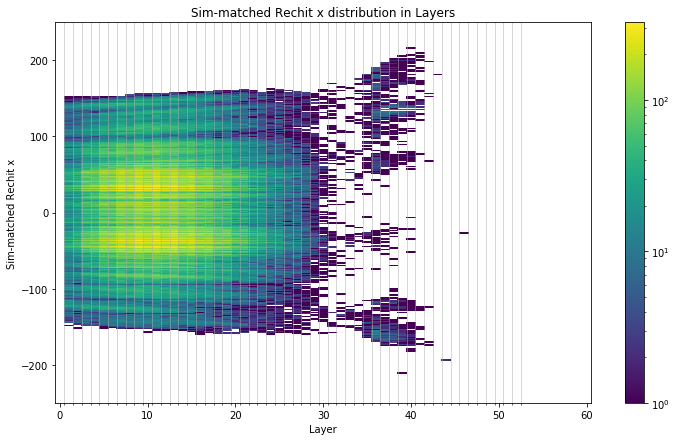

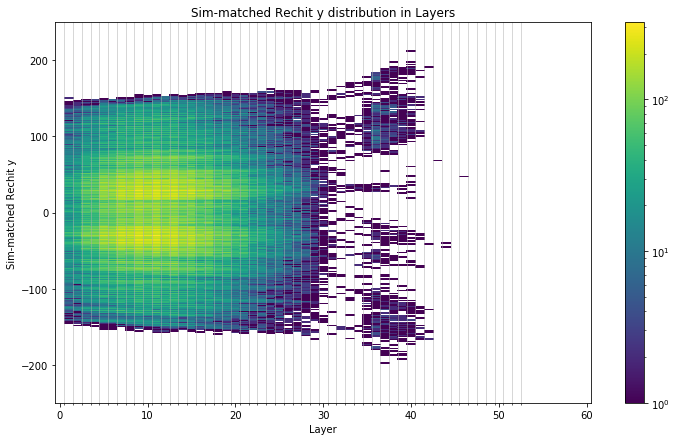

In [19]:
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_x'], 'Sim-matched Rechit x'));
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_y'], 'Sim-matched Rechit y'));



## (Sum of Calibrated Energy of Sim-matched Rechit ) / (Simcluster Energy)

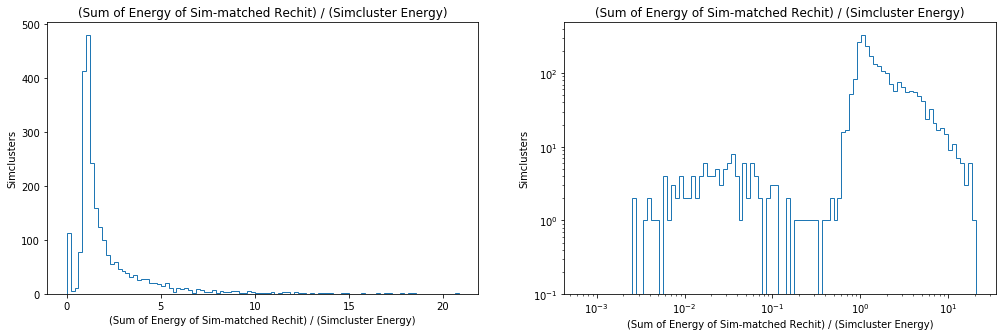

In [20]:
h = np.divide(corrected_rechit_simcluster_energy.flatten().sum(), simcluster[b'simcluster_energy'].flatten())
#h = np.divide(rechit_simcluster[b'rechit_energy'].flatten().sum(), simcluster[b'simcluster_energy'].flatten())

fig = plt.figure(figsize=(17,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", "Simclusters",\
         "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", Nbins = 100)
ax2 = fig.add_subplot(122);
plotHist(ax2, h, "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", "Simclusters",\
         "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", Nbins = 100, xlog=True, ylog=True)
figs.append(fig)

## (Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)

In [21]:
eta_barycentre = np.divide((corrected_rechit_simcluster_energy.content * rechit_simcluster[b'rechit_eta'].content).sum(), \
                            corrected_rechit_simcluster_energy.content.sum())


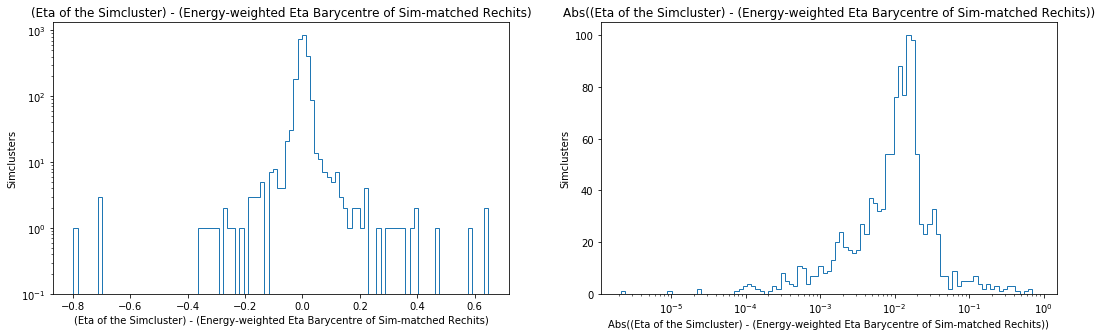

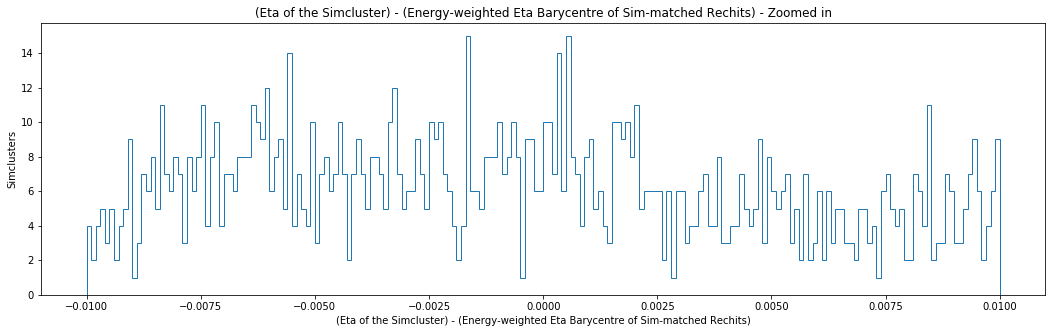

In [22]:
h = simcluster[b'simcluster_eta'].content - eta_barycentre

fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        "Simclusters", "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        Nbins=100, ylog=True)
ax2 = fig.add_subplot(122);
plotHist_absxlog(ax2, h, "Abs((Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits))",\
        "Simclusters", "Abs((Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits))",\
        Nbins=100)
figs.append(fig)

fig, axes = plt.subplots(figsize=(18,5));
plotHist(axes, h, "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        "Simclusters", "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits) - Zoomed in",\
        Nbins=200, range=(-0.01, 0.01))
figs.append(fig)

## (Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)

In [23]:
phi_barycentre = np.divide((corrected_rechit_simcluster_energy.content * rechit_simcluster[b'rechit_phi'].content).sum(), \
                            corrected_rechit_simcluster_energy.content.sum())

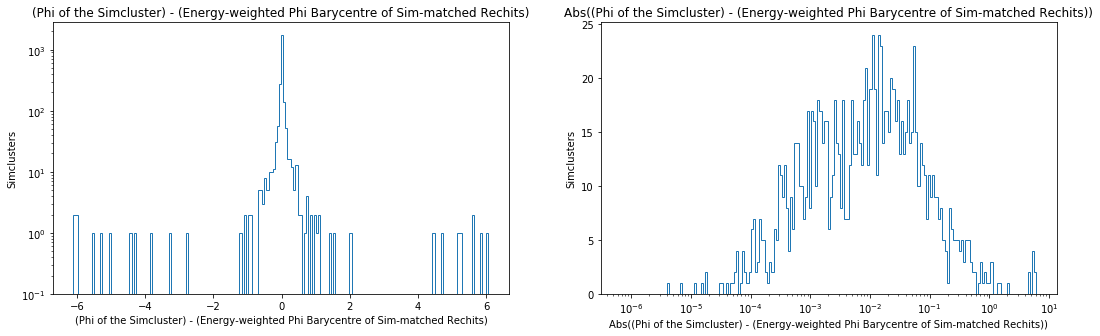

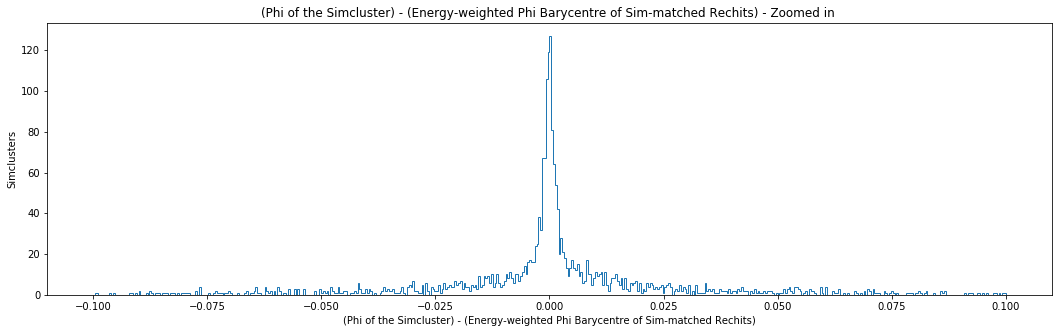

In [24]:
h = simcluster[b'simcluster_phi'].content - phi_barycentre
fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", "Simclusters",\
        "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", Nbins=200, ylog=True)
ax2 = fig.add_subplot(122);
plotHist_absxlog(ax2, h, "Abs((Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits))",\
                 "Simclusters",\
                 "Abs((Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits))", Nbins=200)
figs.append(fig)

fig, axes = plt.subplots(figsize=(18,5));
plotHist(axes, h, "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", "Simclusters",\
        "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits) - Zoomed in ",\
         range= (-0.1, 0.1), Nbins=500)
figs.append(fig)

## Simcluster Energy

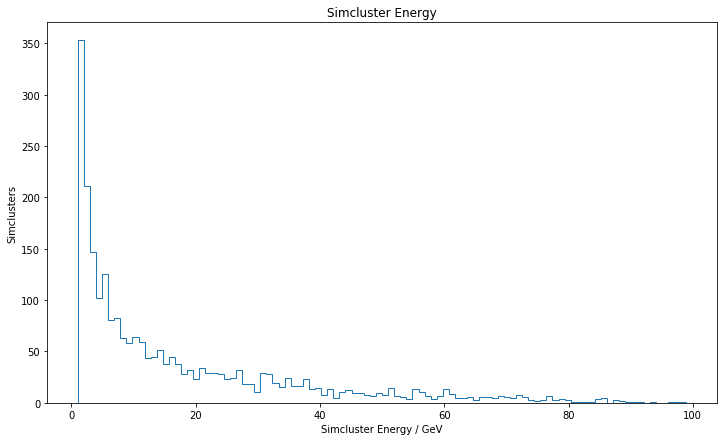

In [25]:
h = simcluster[b'simcluster_energy'].content
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, h, "Simcluster Energy / GeV", "Simclusters", "Simcluster Energy", Nbins=100)
figs.append(fig)

## PID of Simcluster (Information not yet included in NTUP files)

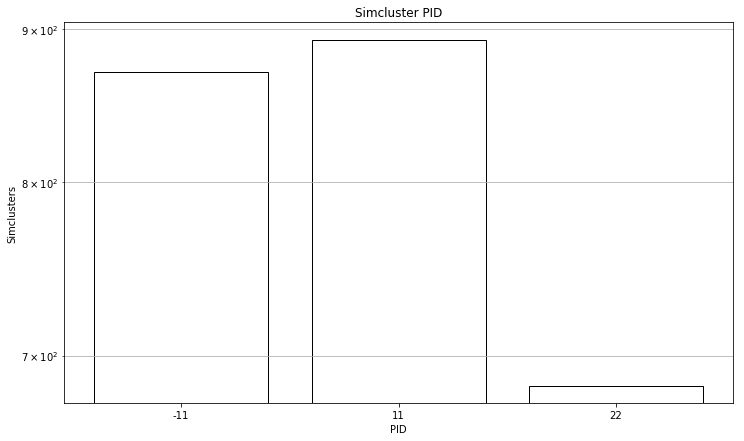

In [26]:
x, y = np.unique(simcluster[b'simcluster_pid'].flatten(), return_counts=True)
x_pos = np.arange(len(x))
fig,axes = plt.subplots(figsize=(12, 7));
axes.bar(x_pos, y, log=True, fill=False)
axes.set_xticks(x_pos)
axes.set_xticklabels(x)
axes.set_title("Simcluster PID")
axes.set_xlabel("PID")
axes.set_ylabel("Simclusters")
plt.grid(True, which='both', axis='y')
figs.append(fig)

## Sim-matched Rechit Multiplicity per Simcluster

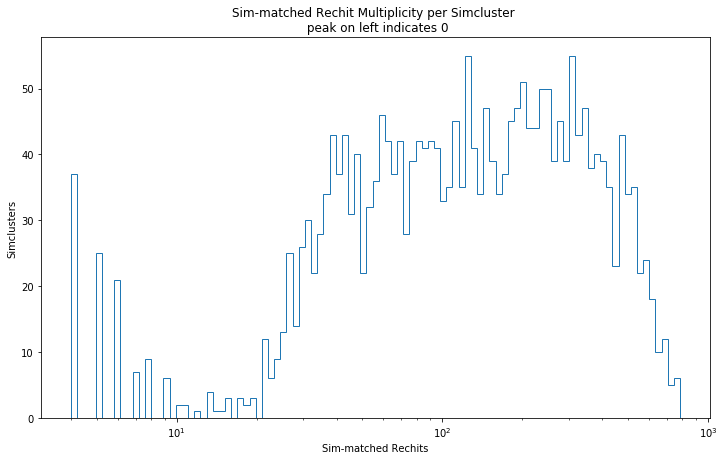

In [27]:
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, valid_sim_indices.flatten().counts+0.01, "Sim-matched Rechits", "Simclusters",\
         "Sim-matched Rechit Multiplicity per Simcluster \n peak on left indicates 0", Nbins = 100 ,xlog=True)
figs.append(fig)

## Simcluster Multiplicity per event

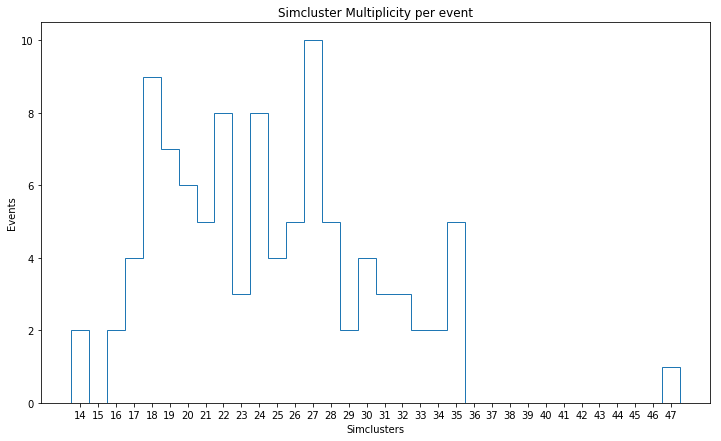

In [28]:
fig,axes = plt.subplots(figsize=(12, 7));
h= valid_sim_indices.counts
plotHist(axes, h, "Simclusters", "Events",\
         "Simcluster Multiplicity per event", Nbins = np.arange(h.min()-0.5,h.max()+1.5,1))
axes.set_xticks(np.arange(h.min(),h.max()+1,1), minor=False)
figs.append(fig)

## Simcluster - First Layer Number

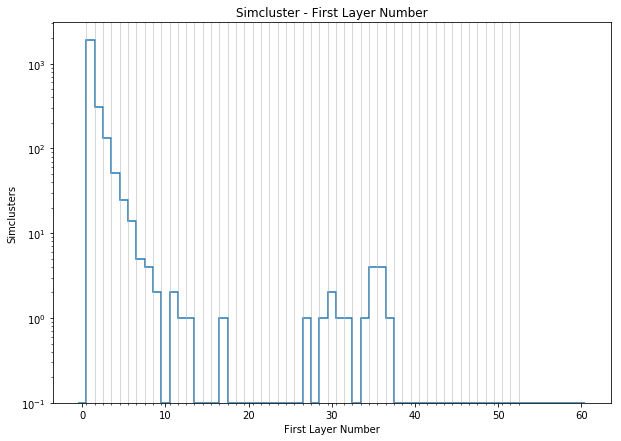

In [29]:
h = simcluster[b'simcluster_layers'].content.min()
figs.append(plotHist_layers(h, "Simclusters", "Simcluster - First Layer Number", xlabel= "First Layer Number"))

## Simcluster - Last Layer Number

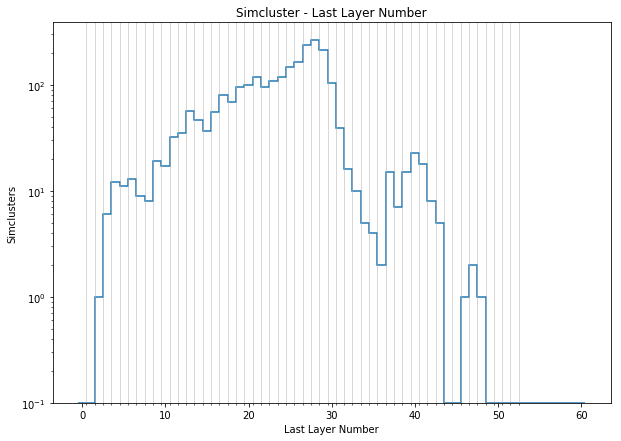

In [30]:
h = simcluster[b'simcluster_layers'].content.max()
figs.append(plotHist_layers(h, "Simclusters", "Simcluster - Last Layer Number", xlabel= "Last Layer Number"))

## No. of rechits in Preprocessed Clusters

In [31]:

preprocessed_clusters_pos = []
preprocessed_clusters_neg = []

preprocessed_clusters_pos_Nedges = []
preprocessed_clusters_neg_Nedges = []

for ievt in tqdm(range(NEvents)):
    g_pos = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] > 0, r=preprocessing_r, layered_norm = layer_norm, algo=grouping_algo)
    nx_graph_pos = nx.Graph()
    list_tmp = list(zip(find(g_pos.Ri)[0], find(g_pos.Ro)[0]))
    nx_graph_pos.add_edges_from(list_tmp)
    preprocessed_clusters_pos.append(awkward.fromiter(nx.connected_components(nx_graph_pos)))
    preprocessed_clusters_pos_Nedges.append(len(list_tmp))
    
    g_neg = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] < 0, r=preprocessing_r, layered_norm = layer_norm, algo=grouping_algo)
    nx_graph_neg = nx.Graph()
    list_tmp = list(zip(find(g_neg.Ri)[0], find(g_neg.Ro)[0]))
    nx_graph_neg.add_edges_from(list_tmp)
    preprocessed_clusters_neg.append(awkward.fromiter(nx.connected_components(nx_graph_neg)))
    preprocessed_clusters_neg_Nedges.append(len(list_tmp))

In [32]:
preprocessed_clusters_pos = awkward.fromiter(preprocessed_clusters_pos)
preprocessed_clusters_neg = awkward.fromiter(preprocessed_clusters_neg)
#preprocessed_clusters_pos and preprocessed_clusters_neg are ids (within each pos/neg event) of rechits in each cluster

def rewrap_into_eventCluster_structure(filelevel_array, target_structure):
    return awkward.JaggedArray.fromcounts(target_structure.counts,\
        (awkward.JaggedArray.fromcounts(target_structure.flatten(0).counts, filelevel_array)))

rechit_idx_map_pos = awkward.fromiter(map(np.where, (rechit[b'rechit_z'] > 0))).flatten()
rechit_idx_map_neg = awkward.fromiter(map(np.where, (rechit[b'rechit_z'] < 0))).flatten()
#map from pos/neg id to event-level id

preprocessed_clusters_pos_gid = rewrap_into_eventCluster_structure(rechit_idx_map_pos[preprocessed_clusters_pos.flatten(1)].flatten(),\
                                  target_structure=preprocessed_clusters_pos)
preprocessed_clusters_neg_gid = rewrap_into_eventCluster_structure(rechit_idx_map_neg[preprocessed_clusters_neg.flatten(1)].flatten(),\
                                  target_structure=preprocessed_clusters_neg)

In [33]:
preprocessed_clusters_counts = np.concatenate([preprocessed_clusters_pos_gid.flatten().counts, \
                                               preprocessed_clusters_neg_gid.flatten().counts])

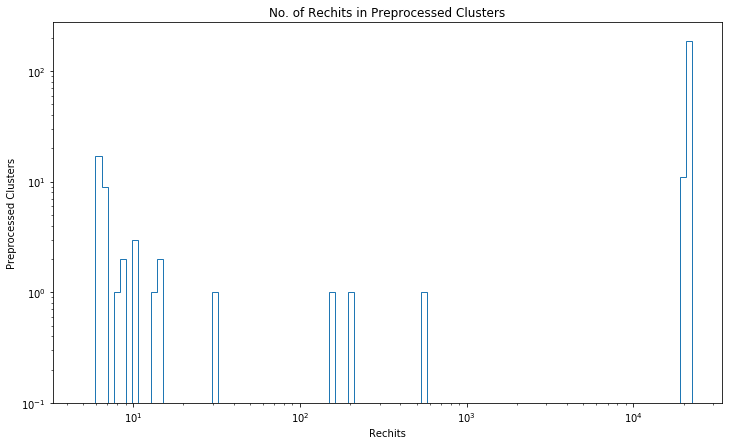

In [34]:
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, preprocessed_clusters_counts, "Rechits", "Preprocessed Clusters",\
         "No. of Rechits in Preprocessed Clusters", Nbins = 100, xlog=True, ylog=True)
figs.append(fig)

## No. of Edges in Events

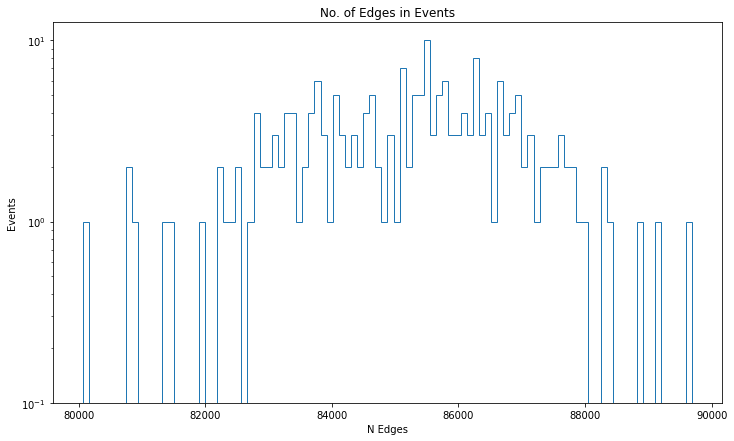

In [35]:
fig,axes = plt.subplots(figsize=(12, 7));
preprocessed_clusters_Nedges = np.concatenate((preprocessed_clusters_pos_Nedges, preprocessed_clusters_neg_Nedges))
plotHist(axes, preprocessed_clusters_Nedges, "N Edges", "Events",\
         "No. of Edges in Events", Nbins = 100, xlog=False, ylog=True)
figs.append(fig)

## Sum of Corrected Energy of Rechits in each Preprocessed Cluster

In [36]:
#rechit_energy_corrected = rechit[b'rechit_energy'] * \
#    awkward.JaggedArray.fromcounts(rechit[b'rechit_energy'].counts,\
#                                   np.take(absorber_weights,rechit[b'rechit_layer'].flatten()))

rechit_energy_corrected = rechit[b'rechit_energy']

In [37]:
rechit_energy_preprocessed_cluster_pos = rewrap_into_eventCluster_structure(rechit_energy_corrected[preprocessed_clusters_pos_gid.flatten(1)].flatten(),\
                                   preprocessed_clusters_pos_gid).flatten(0)
rechit_energy_preprocessed_cluster_neg = rewrap_into_eventCluster_structure(rechit_energy_corrected[preprocessed_clusters_neg_gid.flatten(1)].flatten(),\
                                   preprocessed_clusters_neg_gid).flatten(0)

rechit_energy_sum_preprocessed_cluster = np.concatenate([rechit_energy_preprocessed_cluster_pos.sum(), rechit_energy_preprocessed_cluster_neg.sum()])

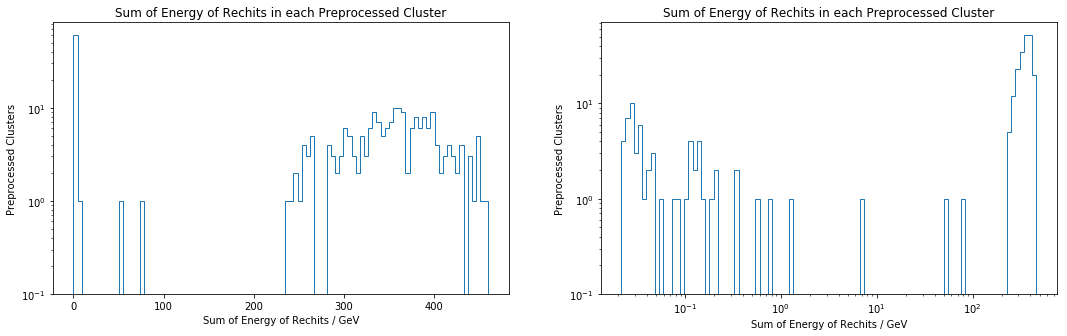

In [38]:
fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, rechit_energy_sum_preprocessed_cluster, "Sum of Energy of Rechits / GeV", "Preprocessed Clusters",\
         "Sum of Energy of Rechits in each Preprocessed Cluster", range=(rechit_energy_sum_preprocessed_cluster.min(), rechit_energy_sum_preprocessed_cluster.max()), Nbins = 100, xlog=False, ylog=True)
ax2 = fig.add_subplot(122);
plotHist(ax2, rechit_energy_sum_preprocessed_cluster, "Sum of Energy of Rechits / GeV", "Preprocessed Clusters",\
         "Sum of Energy of Rechits in each Preprocessed Cluster", Nbins = 100, xlog=True, ylog=True)
figs.append(fig)

## Preprocessed Cluster - First Layer Number


In [39]:
rechit_layer_preprocessed_cluster_pos = rewrap_into_eventCluster_structure((rechit[b'rechit_layer'][preprocessed_clusters_pos_gid.flatten(1)]).flatten(),\
                                   target_structure=preprocessed_clusters_pos).flatten(0)
rechit_layer_preprocessed_cluster_neg = rewrap_into_eventCluster_structure((rechit[b'rechit_layer'][preprocessed_clusters_neg_gid.flatten(1)]).flatten(),\
                                   target_structure=preprocessed_clusters_neg).flatten(0)
rechit_layer_preprocessed_cluster = awkward.JaggedArray.concatenate([rechit_layer_preprocessed_cluster_pos,\
                                                                    rechit_layer_preprocessed_cluster_neg])

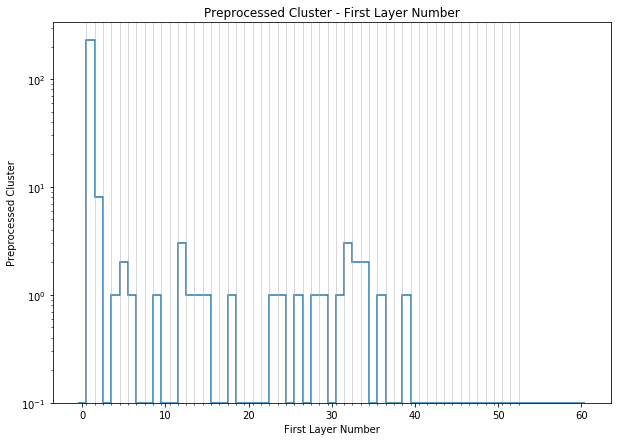

In [40]:
figs.append(plotHist_layers(rechit_layer_preprocessed_cluster.min(),\
                            "Preprocessed Cluster", "Preprocessed Cluster - First Layer Number", xlabel= "First Layer Number"))

## Preprocessed Cluster - Last Layer Number

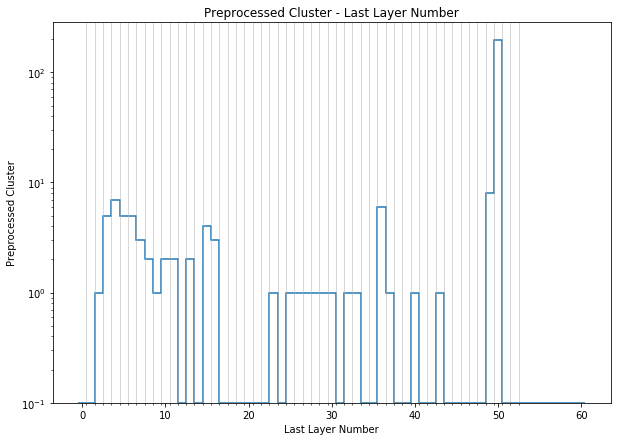

In [41]:
figs.append(plotHist_layers(rechit_layer_preprocessed_cluster.max(),\
                            "Preprocessed Cluster", "Preprocessed Cluster - Last Layer Number", xlabel= "Last Layer Number"))

## Rechit Multiplicity in Greatest Intersection
A simcluster's "Greatest Intersection" is defined as the largest intersection of rechits between this simcluster and any preprocessed cluster (on pos/neg endcap respectively)

In [42]:
def intersect_row(row):
    row = row.tolist()
    return np.intersect1d(row[0], row[1])

def intersect_table(awkward_table):
    return map(intersect_row, awkward_table)

intersection_pos = awkward.fromiter(map(intersect_table, valid_sim_indices[simcluster[b'simcluster_eta']>0].cross(preprocessed_clusters_pos_gid)))
intersection_neg = awkward.fromiter(map(intersect_table, valid_sim_indices[simcluster[b'simcluster_eta']<0].cross(preprocessed_clusters_neg_gid)))

intersection_pos = awkward.JaggedArray.fromcounts(valid_sim_indices[simcluster[b'simcluster_eta']>0].counts,\
    awkward.JaggedArray.fromcounts(np.repeat(preprocessed_clusters_pos_gid.counts, valid_sim_indices[simcluster[b'simcluster_eta']>0].counts), \
                       intersection_pos.flatten()))

intersection_neg = awkward.JaggedArray.fromcounts(valid_sim_indices[simcluster[b'simcluster_eta']<0].counts,\
    awkward.JaggedArray.fromcounts(np.repeat(preprocessed_clusters_neg_gid.counts, valid_sim_indices[simcluster[b'simcluster_eta']<0].counts), \
                       intersection_neg.flatten()))

#structure:
#intersection_pos/neg[event idx][simcluster idx (for pos/neg respectively)][idx of preprocessed cluster(for pos/neg respectively)]

In [43]:
simcluster_energy_pos_neg = np.concatenate([simcluster[b'simcluster_energy'][simcluster[b'simcluster_eta']>0].flatten(),\
                                            simcluster[b'simcluster_energy'][simcluster[b'simcluster_eta']<0].flatten()])
simclusterEnergyCut = (simcluster_energy_pos_neg > 1.0)

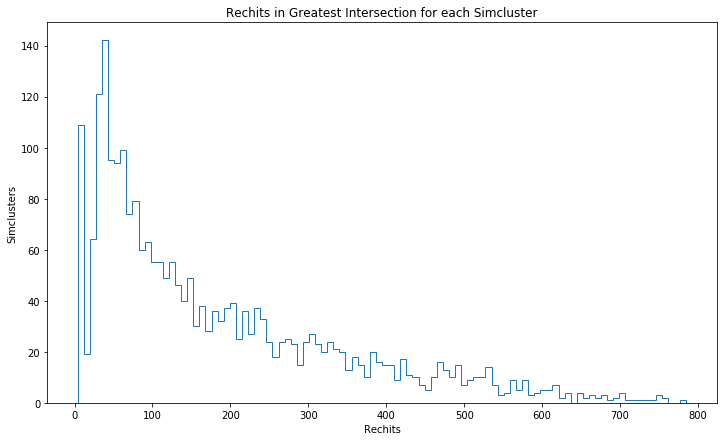

In [44]:
pos_simcluster_grtitsn_counts = np.array(list(map(lambda x: x.counts.max(), intersection_pos.flatten())))
neg_simcluster_grtitsn_counts = np.array(list(map(lambda x: x.counts.max(), intersection_neg.flatten())))
grtitsn_counts = np.concatenate([pos_simcluster_grtitsn_counts, neg_simcluster_grtitsn_counts])
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, grtitsn_counts[simclusterEnergyCut], "Rechits", "Simclusters",\
         "Rechits in Greatest Intersection for each Simcluster", Nbins = 100)
figs.append(fig)

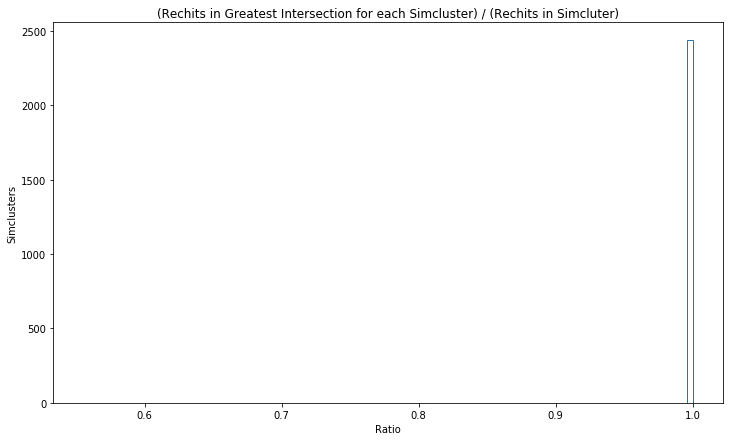

In [45]:
simcluster_counts = np.concatenate([valid_sim_indices[simcluster[b'simcluster_eta']>0].flatten().counts,\
                valid_sim_indices[simcluster[b'simcluster_eta']<0].flatten().counts])
nonzerocut = (simcluster_counts > 0)
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, grtitsn_counts[simclusterEnergyCut & nonzerocut]/simcluster_counts[simclusterEnergyCut & nonzerocut], "Ratio", "Simclusters",\
         "(Rechits in Greatest Intersection for each Simcluster) / (Rechits in Simcluter)", Nbins = 100)
figs.append(fig)

In [46]:
map_tmp = awkward.JaggedArray.fromcounts(valid_sim_indices.counts,\
                                         list(zip(np.repeat(np.arange(valid_sim_indices.shape[0]),valid_sim_indices.counts), np.concatenate(list(map(np.arange, valid_sim_indices.counts))))))

map_posneg2event = np.concatenate([map_tmp[simcluster[b'simcluster_eta']>0].flatten(), map_tmp[simcluster[b'simcluster_eta']<0].flatten()])

## Activate these cells to explore Simclusters with low efficiency:

In [47]:
bad_list = np.where((grtitsn_counts/simcluster_counts < 0.9))[0]

In [53]:
bad_event_list = []
for bad_cluster in bad_list:
    bad_event_idx = map_posneg2event[bad_cluster][0]
    bad_cluster_idx = map_posneg2event[bad_cluster][1]
    bad_eta = simcluster[b'simcluster_eta'][bad_event_idx][bad_cluster_idx]
    if (np.abs(bad_eta) < 2.2):
        
        bad_event_list.append(bad_cluster)
        
bad_event_list = np.array(bad_event_list)
bad_event_list

array([ 211,  625, 1082])

Rechits in greatest intersection 76
Rechits in simcluster 76
Ratio/Efficiency 1.0
Event and simcluster id [0 2]
Simcluster Eta 1.886383
Simcluster Energy 5.917585
Simcluster rechit counts in event
 [351 320  76 493 116  54  36 274 426 189 252 239  38  57  84 188 516 392
 313]


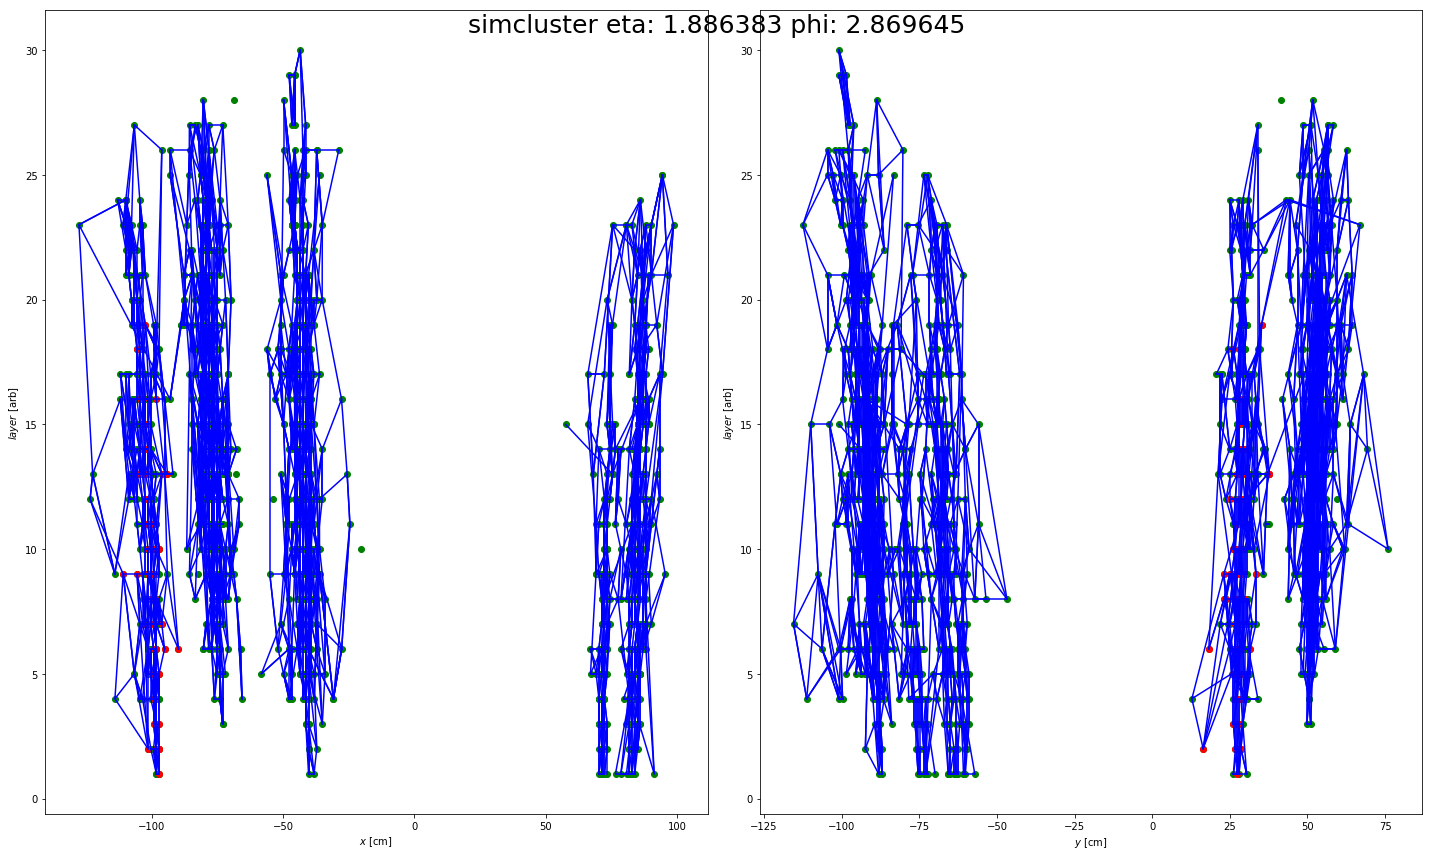

In [54]:

idx_simcluster = 1
print("Rechits in greatest intersection", grtitsn_counts[idx_simcluster])
print("Rechits in simcluster", simcluster_counts[idx_simcluster])
print("Ratio/Efficiency", (grtitsn_counts/simcluster_counts)[idx_simcluster])
print("Event and simcluster id", map_posneg2event[idx_simcluster])

event_idx = map_posneg2event[idx_simcluster][0]
cluster_idx = map_posneg2event[idx_simcluster][1]
print("Simcluster Eta", simcluster[b'simcluster_eta'][event_idx][cluster_idx])
print("Simcluster Energy", simcluster[b'simcluster_energy'][event_idx][cluster_idx])
print("Simcluster rechit counts in event\n", valid_sim_indices[event_idx].counts)
#print("Simcluster PID in event\n", simcluster[b'simcluster_pid'][event_idx])



mask  = rechit[b'rechit_z'][event_idx] > 0.0
all_sim_hits = np.unique(valid_sim_indices[event_idx][cluster_idx])
sim_hits_mask = np.zeros(rechit[b'rechit_z'][event_idx].size, dtype=np.bool)
sim_hits_mask[all_sim_hits] = True
simmatched = np.where(sim_hits_mask[mask])[0]
g2 = preprocessing_algo(rechit, valid_sim_indices, ievt = event_idx, mask = rechit[b'rechit_z'][event_idx] > 0, r=preprocessing_r, layered_norm=layer_norm)

fig, ax0, ax1 = draw_sample_validation(g2.X,g2.Ri,g2.Ro,g2.y,sim_list=g2.simmatched, particular_simcluster_list=simmatched)
fig.suptitle('simcluster eta: ' + str(simcluster[b'simcluster_eta'][event_idx][cluster_idx]) + " phi: " + str(simcluster[b'simcluster_phi'][event_idx][cluster_idx]), fontsize=25);



## Sum of Corrected Energy in Greatest Intersection

In [55]:
grtitsn_pos = intersection_pos.flatten()[awkward.fromiter(map(lambda x: [np.argmax(x.counts)],intersection_pos.flatten()))].flatten()
grtitsn_neg = intersection_neg.flatten()[awkward.fromiter(map(lambda x: [np.argmax(x.counts)],intersection_neg.flatten()))].flatten()

In [56]:
energy_grtitsn_pos = rewrap_into_eventCluster_structure(rechit_energy_corrected[awkward.JaggedArray.fromcounts(intersection_pos.counts, grtitsn_pos).flatten(1)].flatten(),\
                                   target_structure = awkward.JaggedArray.fromcounts(intersection_pos.counts, grtitsn_pos))
energy_grtitsn_neg = rewrap_into_eventCluster_structure(rechit_energy_corrected[awkward.JaggedArray.fromcounts(intersection_neg.counts, grtitsn_neg).flatten(1)].flatten(),\
                                   target_structure = awkward.JaggedArray.fromcounts(intersection_neg.counts, grtitsn_neg))

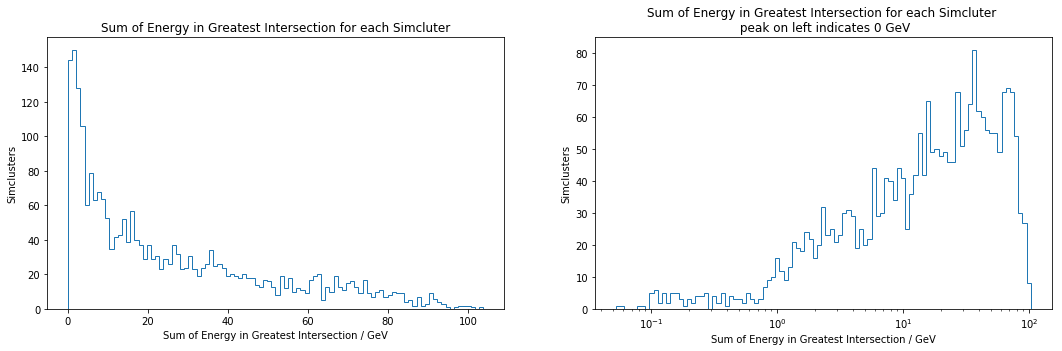

In [57]:
h = np.concatenate([energy_grtitsn_pos.flatten().sum(), energy_grtitsn_neg.flatten().sum()])
fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h[simclusterEnergyCut], "Sum of Energy in Greatest Intersection / GeV", "Simclusters",\
         "Sum of Energy in Greatest Intersection for each Simcluter", Nbins = 100)
ax2 = fig.add_subplot(122);
plotHist(ax2, h[simclusterEnergyCut]+0.00001, "Sum of Energy in Greatest Intersection / GeV", "Simclusters",\
         "Sum of Energy in Greatest Intersection for each Simcluter \n peak on left indicates 0 GeV", Nbins = 100, xlog=True)
figs.append(fig)

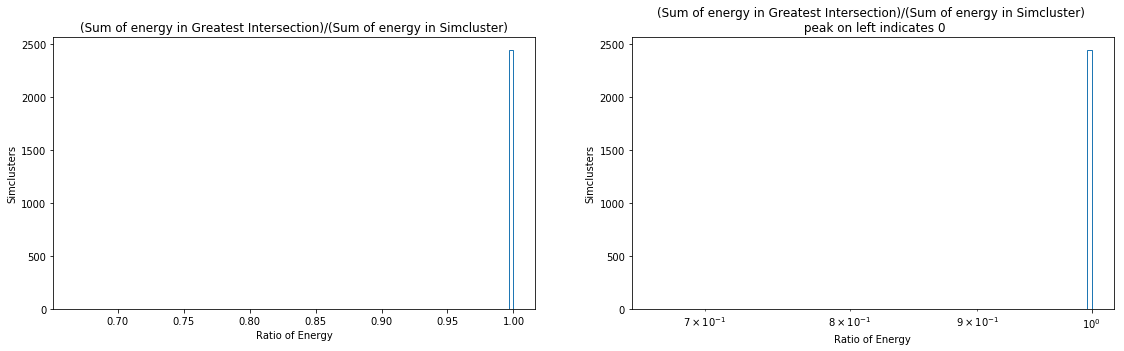

In [58]:
simcluster_energy_posneg = np.concatenate([corrected_rechit_simcluster_energy[simcluster[b'simcluster_eta']>0].flatten().sum(),\
                                           corrected_rechit_simcluster_energy[simcluster[b'simcluster_eta']<0].flatten().sum()])
nonzeromask = (simcluster_energy_posneg > 0)

fig = plt.figure(figsize=(19,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h[simclusterEnergyCut & nonzeromask]/simcluster_energy_posneg[simclusterEnergyCut & nonzeromask], "Ratio of Energy", "Simclusters",\
         "(Sum of energy in Greatest Intersection)/(Sum of energy in Simcluster)", Nbins = 100)
ax2 = fig.add_subplot(122);
plotHist(ax2, h[simclusterEnergyCut & nonzeromask]/simcluster_energy_posneg[simclusterEnergyCut & nonzeromask] + 0.00001, "Ratio of Energy", "Simclusters",\
         "(Sum of energy in Greatest Intersection)/(Sum of energy in Simcluster) \n peak on left indicates 0", Nbins = 100, xlog=True)
figs.append(fig)

## Greatest Intersection - First Layer Number  

In [59]:
layer_grtitsn_pos = rewrap_into_eventCluster_structure((rechit[b'rechit_layer'][awkward.JaggedArray.fromcounts(intersection_pos.counts, grtitsn_pos).flatten(1)]).flatten(),\
                                   target_structure = awkward.JaggedArray.fromcounts(intersection_pos.counts, grtitsn_pos)).flatten()
layer_grtitsn_neg = rewrap_into_eventCluster_structure((rechit[b'rechit_layer'][awkward.JaggedArray.fromcounts(intersection_neg.counts, grtitsn_neg).flatten(1)]).flatten(),\
                                   target_structure = awkward.JaggedArray.fromcounts(intersection_neg.counts, grtitsn_neg)).flatten()


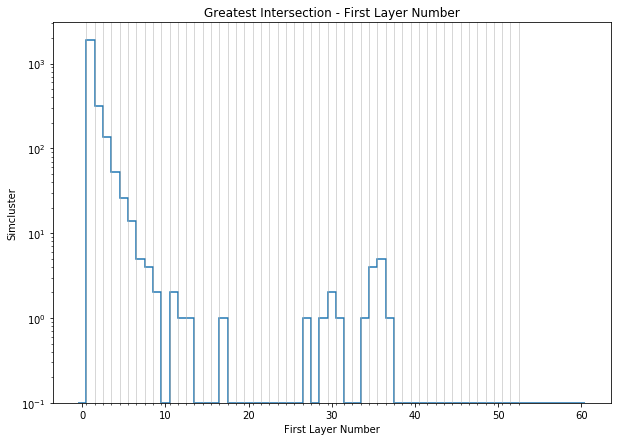

In [60]:
figs.append(plotHist_layers(np.concatenate([layer_grtitsn_pos.min(), layer_grtitsn_neg.min()])[simclusterEnergyCut],\
                            "Simcluster", "Greatest Intersection - First Layer Number", xlabel= "First Layer Number"))

## Greatest Intersection - Last Layer Number  

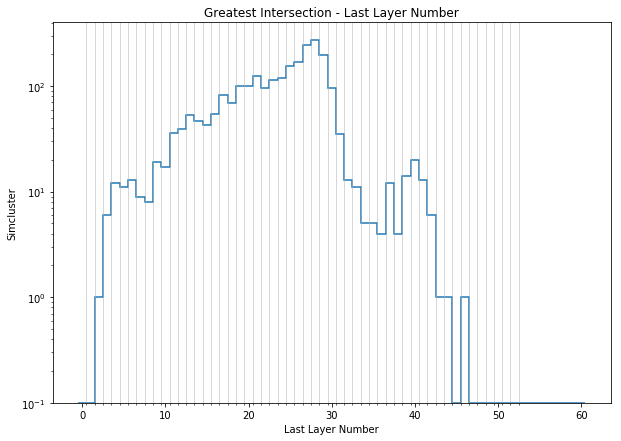

In [61]:
figs.append(plotHist_layers(np.concatenate([layer_grtitsn_pos.max(), layer_grtitsn_neg.max()])[simclusterEnergyCut],\
                            "Simcluster", "Greatest Intersection - Last Layer Number", xlabel= "Last Layer Number"))

## Efficiency of Preprocessing Against Eta of Simcluster

In [62]:
def plotHistRatio(axes, dataNumerator, dataNumeratorLabel, dataDenominator, dataDenominatorLabel, xlabel, ylabelNumerator, ylabelDenominator, title, xticks, Nbins = 100, range=None, ylog=False):
    fig = plt.figure(figsize=(12,8), constrained_layout=True);
    gs = fig.add_gridspec(5, 1)
    ax1 = fig.add_subplot(gs[:4, 0])
    ax1.set_ylabel(ylabelNumerator)
    ax1.set_title(title)
    h_numerator, bins,_ = ax1.hist(dataNumerator, bins=Nbins, range=range, histtype='step', log=ylog, label = dataNumeratorLabel); 
    h_denominator,_,_ = ax1.hist(dataDenominator, bins=bins, range=range, histtype='step', log=ylog, label = dataDenominatorLabel);
    plt.legend(loc='upper center')
    
    
    ax2 = fig.add_subplot(gs[4, 0], sharex=ax1);
    ax2.set_xlabel(xlabel)
    ax2.set_xticks(xticks, minor=True)
    ax2.set_ylim((0.0,1.0))
    ax2.set_ylabel(ylabelDenominator)
    #ax2.plot((bins[:-1] + bins[1:]) / 2, h_numerator / h_denominator)
    ax2.bar((bins[:-1] + bins[1:]) / 2, h_numerator / h_denominator, align='center', width=bins[1] - bins[0], fill=False)
    plt.grid(True, which='major')
    #print((bins[:-1] + bins[1:]) / 2)
    return fig;

In [63]:
nonzerocut = (simcluster_counts > 0)
efficiency_simcluster_idx = np.where(grtitsn_counts[simclusterEnergyCut & nonzerocut]/simcluster_counts[simclusterEnergyCut & nonzerocut] > 0.9)[0]

/Users/sitongan/miniconda3/envs/ldrd/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


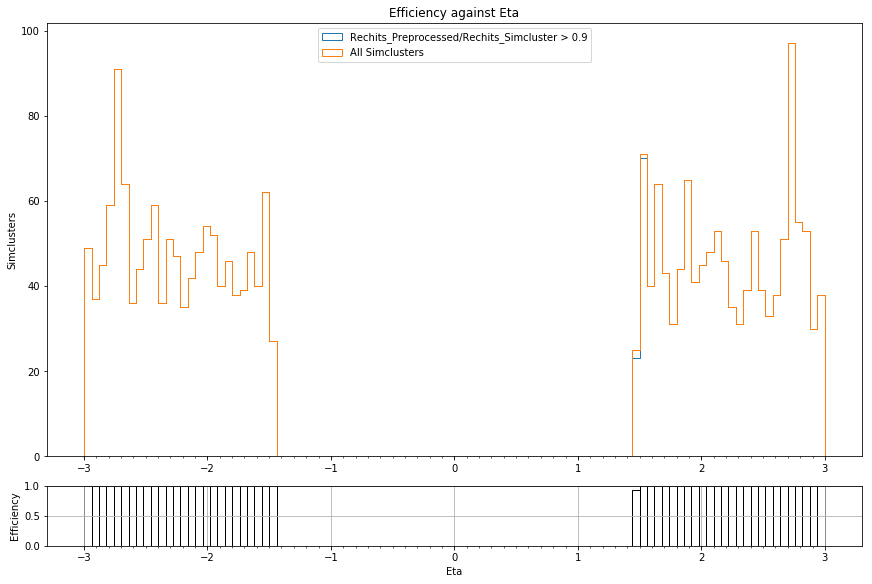

In [64]:
simcluster_eta_pos_neg = np.concatenate([simcluster[b'simcluster_eta'][simcluster[b'simcluster_eta']>0].flatten(),\
simcluster[b'simcluster_eta'][simcluster[b'simcluster_eta']<0].flatten()])

fig = plotHistRatio(axes, simcluster_eta_pos_neg[simclusterEnergyCut & nonzerocut][efficiency_simcluster_idx], "Rechits_Preprocessed/Rechits_Simcluster > 0.9",\
              simcluster_eta_pos_neg[simclusterEnergyCut & nonzerocut], "All Simclusters" , "Eta", "Simclusters", "Efficiency",\
         "Efficiency against Eta", Nbins = 100, xticks=np.arange(-3,3,0.1))
figs.append(fig)


## Efficiency of Preprocessing Against Phi of Simcluster

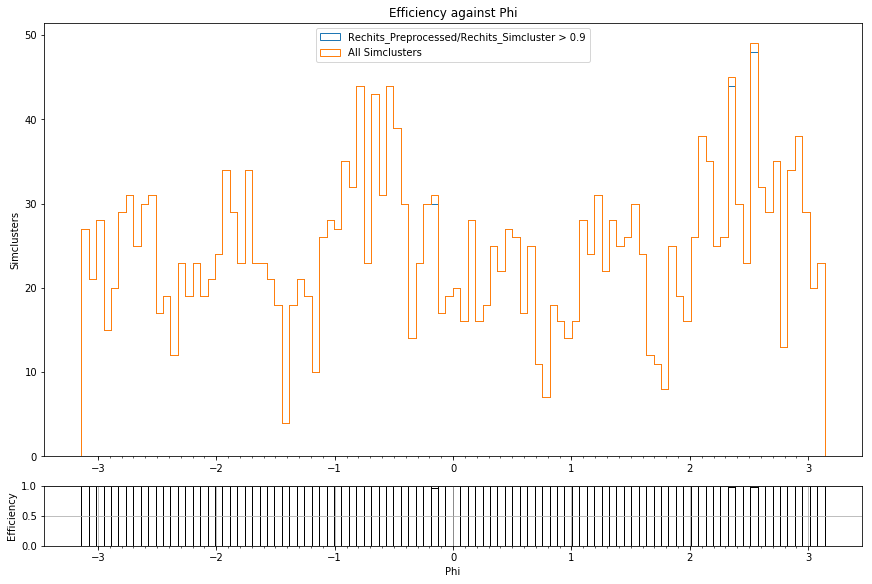

In [65]:
simcluster_phi_pos_neg = np.concatenate([simcluster[b'simcluster_phi'][simcluster[b'simcluster_eta']>0].flatten(),\
simcluster[b'simcluster_phi'][simcluster[b'simcluster_eta']<0].flatten()])

fig = plotHistRatio(axes, simcluster_phi_pos_neg[simclusterEnergyCut & nonzerocut][efficiency_simcluster_idx], "Rechits_Preprocessed/Rechits_Simcluster > 0.9",\
              simcluster_phi_pos_neg[simclusterEnergyCut & nonzerocut], "All Simclusters" , "Phi", "Simclusters", "Efficiency",\
         "Efficiency against Phi", Nbins = 100, xticks=np.arange(-3,3,0.1))
figs.append(fig)



## Efficiency of Preprocessing Against Energy of Simcluster

/Users/sitongan/miniconda3/envs/ldrd/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


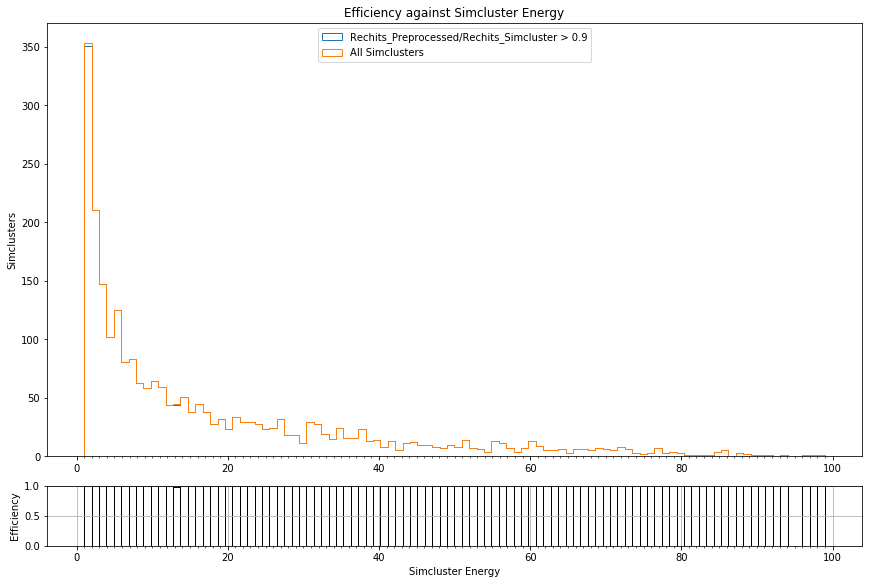

In [66]:
simcluster_energy_pos_neg = np.concatenate([simcluster[b'simcluster_energy'][simcluster[b'simcluster_eta']>0].flatten(),\
simcluster[b'simcluster_energy'][simcluster[b'simcluster_eta']<0].flatten()])

fig = plotHistRatio(axes, simcluster_energy_pos_neg[simclusterEnergyCut & nonzerocut][efficiency_simcluster_idx], "Rechits_Preprocessed/Rechits_Simcluster > 0.9",\
              simcluster_energy_pos_neg[simclusterEnergyCut & nonzerocut], "All Simclusters" , "Simcluster Energy", "Simclusters", "Efficiency",\
         "Efficiency against Simcluster Energy", Nbins = 100, xticks=np.arange(0,100,1.0))
figs.append(fig)




## Output

In [67]:
import matplotlib.backends.backend_pdf
outname = preprocessing_string + '.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(outname)
for fig in figs: 
    pdf.savefig(fig)
pdf.close()